# Open Traffic Reporter: Map-Matching Validation

In [1]:
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib.cm import viridis
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
from scipy.stats import cumfreq
%matplotlib inline

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
cityName = 'San Francisco'

## 1. Generate Random Routes

#### Using Mapzen Venues (requires good WOF coverage)

In [3]:
routeList = val.get_routes_by_length(cityName, 1, 5, 10, mapzenKey)

#### Using Google Maps POIs (better for non-Western capitals)

In [3]:
# routeList = val.get_POI_routes_by_length(cityName, 1, 5, 10, gmapsKey)

#### Or load a specific set of routes you've already saved

In [5]:
# routeList = pickle.load(open('sf_routes.pkl','rb'))

#### Optionally save route list for future use

In [6]:
# pickle.dump(routeList, open('sf_routes.pkl','wb'))

## 2. Iterate Through Routes and Score the Matches

In [4]:
noiseLevels = np.linspace(0, 100, 21)
sampleRates = [1, 5, 10, 20, 30]
df, speedDf = val.get_route_metrics(routeList, sampleRates, noiseLevels)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

### Check for Pattern Failure 

#### Routes where Open Traffic Reporter returned 0 segments

In [5]:
try:
    df[df['segments'] == -1].plot('sample_rate','noise',kind='scatter',s=25, alpha=0.4)
except TypeError:
    print("Nothing to see here.")

Nothing to see here.


#### Routes with 0 Segment Matches

In [6]:
try:
    df[df['segments'] == 1].plot('sample_rate','noise',kind='scatter',s=25, alpha=0.6)
except TypeError:
    print("Nothing to see here.")

Nothing to see here.


## 3. Visualize the Scores

### Distance-based Metrics

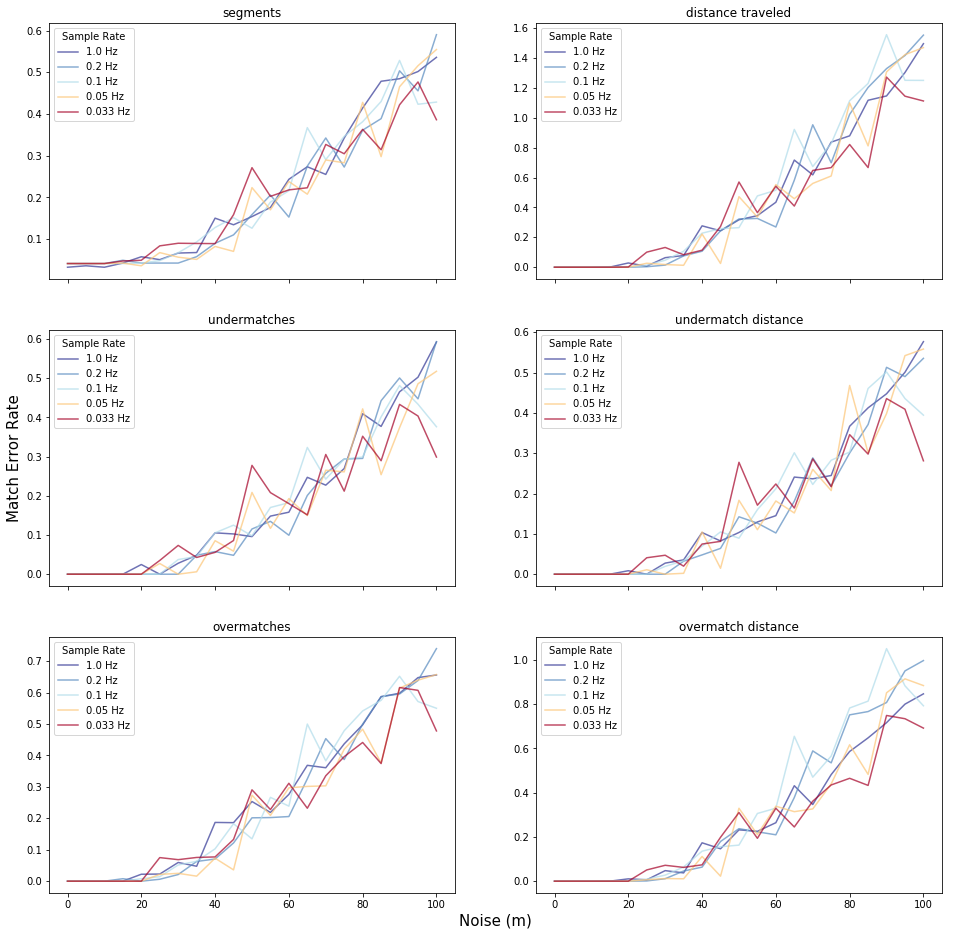

In [7]:
val.plot_distance_metrics(df, sampleRates)

### Speed-based Metrics

Mapzen's map-matching algorithm relies on a kind of probabilistic model known as a Hidden Markov Model (HMM). Because HMM's are probabilistic, the match returned by the algorithm will always be a best guess. However, this best guess may still be far from the "truth". Thus, we want some method for filtering out match results that just aren't realistic. 

#### Calculate and plot the optimal speed error threshold

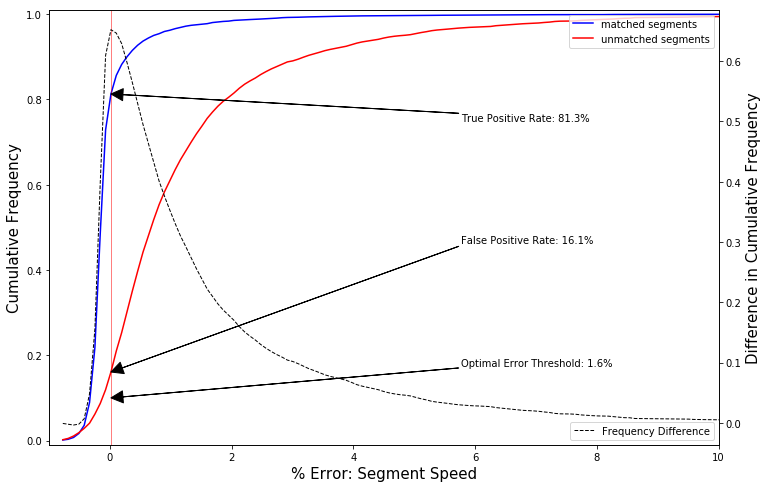

In [8]:
speedErrorThreshold = val.get_optimal_speed_error_threshold(speedDf, plot=True)

#### Map Matching Accuracy Using One-Size-Fits-All Speed Error Threshold

Statistical accuracy measures the fraction of samples correctly identified as either true positives or true negatives, or in our case, matches and misses, respectively.

$$ \text{Accuracy} = \frac{\text{True Positives} \ + \ \text{True Negatives}}{\text{Total Population}} =  \frac{\text{# Matches} \ + \ \text{# Misses}}{\text{# Segments}}$$

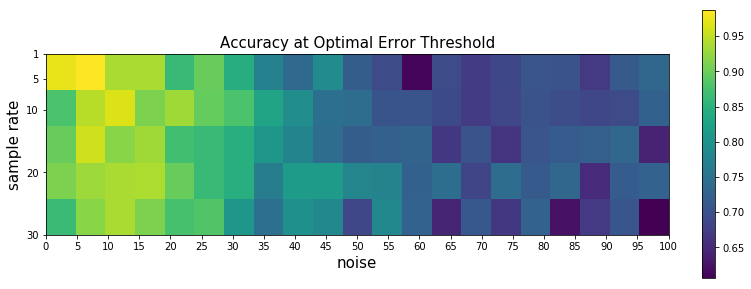

In [28]:
oneSizeFitsAll = val.plot_accuracy_heatmap(speedDf, [speedErrorThreshold], sampleRates, noiseLevels)

#### Calculate optimal thresholds for each sample rate

GPS sample rate is likely to be fixed for a given data provider. We can thus tune our cutoff threshold based on the sample rate which should improve the accuracy of our matches overall.

In [29]:
thresholdsByRate = []
for rate in sampleRates:
    df = speedDf[speedDf['sample_rate'] == rate]
    threshold = val.get_optimal_speed_error_threshold(df, plot=False, saveFig=False)
    thresholdsByRate.append(threshold)

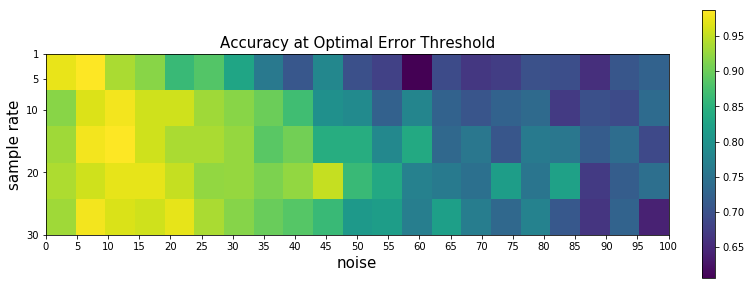

In [30]:
accBySampleRate = val.plot_accuracy_heatmap(speedDf, thresholdsByRate, sampleRates, noiseLevels)

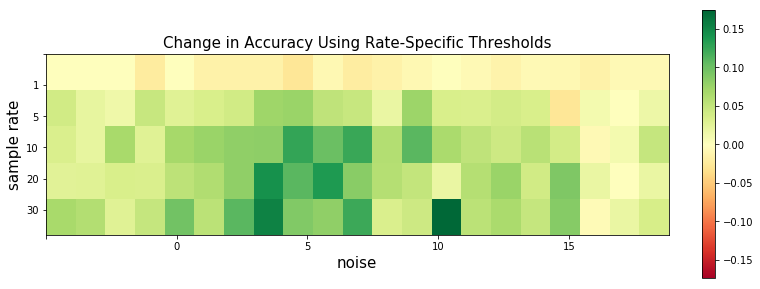

In [45]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlabel("noise", fontsize=15)
ax.set_ylabel("sample rate", fontsize=15)
ax.set_xticks(np.arange(min(noiseLevels), max(noiseLevels),
    len(noiseLevels)))
ax.set_yticks(np.arange(min(sampleRates), max(sampleRates),
    len(sampleRates)))
ax.set_xticklabels([''] + map(str, (map(int, noiseLevels))))
ax.set_yticklabels([''] + map(str, (map(int, sampleRates))))
accDiff = accBySampleRate - oneSizeFitsAll
limit = np.max(np.abs(accDiff))
im = ax.imshow(b - a, cmap='RdYlGn', vmin=-limit, vmax=limit, extent=[min(noiseLevels),max(noiseLevels),max(sampleRates),min(sampleRates)])
ax.set_title("Change in Accuracy Using Rate-Specific Thresholds", fontsize=15)
plt.colorbar(im, fraction=0.02)

In [48]:
ax.get_ybound()

(1.0, 30.0)

## 5. Visualize Routes

In [15]:
geojsonList = [trace for trace in os
               .listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(geojsonList)
val.generate_route_map(fname, 14)

In [21]:
fname

'../data/trace_Wexford Underwriting Managers_to_Ebanista Inc_w_75.0_m_noise_at_0.2_Hz.geojson'

## 6. Save the Scores to Master File

In [20]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]
df.to_csv('../data/master_scores.csv', index=False)